# Alpha系列——组合优化概述

在股票投资组合管理中，核心工作就是两个，其中一个是预测（alpha挖掘），另一个就是组合优化。在这边教程中，我们基于实战视角，介绍了各种组合优化场景，并给出相应的实验代码。

## 股票投资组合优化工作流简介

![work flow](https://raw.githubusercontent.com/feynman0825/markdown_pictures/master/quant%20equity%20workflow.png)

#### 数据搜集

第一步当然是数据搜集了，没有数据啥都干不了。搜集数据是一个苦活、脏活、累活，但它能帮助你构建数据上的竞争优势。在数据维度上，大致我们分为行情数据、财务数据、高频数据、宏观经济数据、三方投研数据、舆情数据以及不属于任何一类的其他数据。在个人投资者和机构投资者很大的一个竞争能力上的差异就是在数据的广度和丰度上，大部分散户还是基于低频历史行情阶段。在数据科学里，我们认为最结果影响最重要的是数据，远远大于算法本身。

#### Alpha构建

在这个环节大致包含两个流程，分别是alpha研究和alpha组合。在研究阶段，我们要找出信息含量高，能够产生alpha因子，当然还会对alpha的生成来源和结构做探索和检验，现在主要的手段是统计检验和可视化；在alpha组合阶段，我们会把所有的alpha因子组合在一起，在这里阶段我们会处理alpha因子之间的相关性，大致上就是把之间收集到的alpha通过信息最大化或者alpha最大化的方式结合起来。在这个阶段，数据质量和预测对alpha起到了决定性的作用。

#### 组合构建

组合构建阶段的任务就是综合收益（alpha向量）、风险以及交易者自身的偏好或者约束。对于风险的建模，首先我们要决定合适的风险度量及风险建模方法，到底是协方差矩阵就足够描述风险了，还是要用VAR或者risk parity进行建模，业界比较普遍的做法是用风险模型来对系统系风险进行建模。然后就是定义目标函数，是收益最大化、风险最小化、夏普或IR最大化还是其他的效用函数，业界比较普遍的做法是用风险厌恶表述，即$w^{\prime} \mu - \lambda w^{\prime} \Sigma w$。最后，我们可能还有一些其他的约束，比如对空约束、净杠杆约束、单头寸范围约束、行业头寸约束等等，这些或满足投资者的偏好或先验信息，或为了满足投资机构本身的风险管理制度。

#### 交易执行

组合构建完后，实际上我们得到的是理想组合和交易列表，这个交易列表可以理解为让当前组合变换到理想组合。在交易执行中，我们会面临很多复杂的问题，比如如何执行这些交易？分笔缓慢得执行还是激进地下单？alpha的预测能力衰减程度如何？在回测中，我们大多数考虑的是确定性的线性交易成本，而市场冲击造成的成本更多是非线性的（二次型）。对这些场景的完全建模将是非常复杂的，实际中在这部分对于小资金基本是激进一次性下单，大资金的话一般会把具体的交易执行给到交易员，由交易员具体把控。

总结下，可以看到在给出了alpha预测向量后，我们基本上转而在解决最优化问题。而最优化问题也是我们在这篇教程中的核心议题。

## 常见组合优化问题

#### 马科维茨问题（经典均值方差优化）

\begin{align*}
\mathop{maximize} \quad & \mu^{\prime}w − \gamma w^{\prime} \Sigma w\\
\mathop{subject \, to} \quad & \boldsymbol{1}w=1, w \in \mathcal{W}
\end{align*}

但这个经典无约束的均值方差问题很敏感，权重向量很容易发散。所以在实践中，我们会加入一些权重约束。

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cvxpy as cvx
from sklearn.linear_model import LinearRegression

In [39]:
## 获取数据
start_date = '2020-02-11'
end_date = '2021-05-07'
instruments =['512700.HOF','515000.HOF','159902.ZOF','159920.ZOF','512400.HOF','515700.HOF','159938.ZOF','159915.ZOF','512580.HOF','512690.HOF','510330.HOF','512980.HOF','513500.HOF','512680.HOF','513100.HOF','512880.HOF','513050.HOF']

data = DataSource('bar1d_CN_FUND').read(instruments, start_date=start_date, end_date=end_date, fields=['close'])
benchmark = D.history_data('000300.SHA',start_date,end_date,fields=['close'])

# 整理数据
data = pd.pivot_table(data,values='close',index=['date'],columns=['instrument'])
benchmark_returns = benchmark.drop('instrument',axis=1).set_index('date').pct_change().dropna()
returns = data.pct_change().dropna()
# returns['cash'] = 0.002

meanReturns = returns.mean()
stdReturns = returns.std()
covMatrix = np.cov(returns.T)
reg=LinearRegression()
reg.fit(benchmark_returns,returns)
B = reg.coef_
returns

instrument,159902.ZOF,159915.ZOF,159920.ZOF,159938.ZOF,510330.HOF,512400.HOF,512580.HOF,512680.HOF,512690.HOF,512700.HOF,512880.HOF,512980.HOF,513050.HOF,513100.HOF,513500.HOF,515000.HOF,515700.HOF
date,,,,,,,,,,,,,,,,,
2020-02-12,0.018417,0.030303,0.005906,0.010000,0.008605,0.052039,0.037851,0.020202,0.004509,0.002616,0.017076,0.024123,0.008626,0.025833,0.017575,0.018842,0.040210
2020-02-13,-0.007347,-0.008973,-0.002609,-0.009901,-0.007026,-0.001337,-0.009412,-0.009901,-0.008977,-0.006957,-0.016789,-0.019272,0.005921,0.056913,0.040301,-0.004795,-0.010084
2020-02-14,0.005978,-0.000503,0.004578,0.002667,0.007076,0.024096,-0.005938,0.001250,-0.002717,0.007881,0.018143,0.002183,-0.003270,-0.044556,-0.042997,-0.000688,-0.010187
2020-02-17,0.031409,0.042275,0.005859,0.021942,0.020828,0.020915,0.031063,0.066167,0.013624,0.019983,0.052411,0.031590,0.014436,-0.008479,0.006228,0.037879,0.042024
2020-02-18,-0.000549,0.009174,-0.012298,-0.002602,-0.004671,0.003841,0.019699,0.030445,-0.007168,-0.006814,-0.006972,0.012672,-0.010349,-0.034960,-0.014147,0.007299,0.003292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-28,0.006848,0.022538,0.002653,0.011861,0.007667,0.001838,0.019199,0.007663,0.025095,0.000000,0.002959,0.009913,0.003378,-0.003437,-0.001555,0.004566,0.026369
2021-04-29,0.006582,0.001017,0.007275,-0.005410,0.008584,0.011009,0.002457,0.001901,-0.002226,0.016317,0.024582,-0.002454,0.003848,0.002802,0.004282,0.001136,0.000494
2021-04-30,-0.004141,0.012534,-0.015102,0.018132,-0.008317,-0.005445,0.020425,-0.034156,-0.010037,-0.014526,-0.010557,-0.009840,-0.025395,-0.007307,0.000000,0.003405,0.019259


In [48]:
B

array([[1.1443301 ],
       [1.2179074 ],
       [0.612148  ],
       [0.8764337 ],
       [0.9865658 ],
       [1.1990108 ],
       [1.090183  ],
       [1.1073022 ],
       [1.2119395 ],
       [0.5668468 ],
       [1.2513231 ],
       [0.7966421 ],
       [0.8315789 ],
       [0.72143745],
       [0.51474124],
       [1.1658688 ],
       [1.3809456 ]], dtype=float32)

In [40]:
def MV_problem():
    n = len(meanReturns)
    w = cvx.Variable(n)
    gamma = cvx.Parameter(nonneg=True)
    ret = meanReturns.values.T*w 
    risk = cvx.quad_form(w, covMatrix)
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
                   [cvx.sum(w) == 1])
    return prob,ret,risk,gamma

def plot_frontier(prob_fun,show_mv=False):
    prob,ret,risk,gamma = prob_fun()
    SAMPLES = 100
    risk_data = np.zeros(SAMPLES)
    ret_data = np.zeros(SAMPLES)
    gamma_vals = np.logspace(-2, 3, num=SAMPLES)
    for i in range(SAMPLES):
        gamma.value = gamma_vals[i]
        prob.solve()
        risk_data[i] = cvx.sqrt(risk).value
        ret_data[i] = ret.value
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(risk_data, ret_data, 'g-',label='prob')
    plt.plot(stdReturns, meanReturns, 'ro')
    if show_mv:
        mv_prob,mv_ret,mv_risk,gamma = MV_problem()
        mv_risk_data = np.zeros(SAMPLES)
        mv_ret_data = np.zeros(SAMPLES)
        gamma_vals = np.logspace(-2, 3, num=SAMPLES)
        for i in range(SAMPLES):
            gamma.value = gamma_vals[i]
            mv_prob.solve()
            mv_risk_data[i] = cvx.sqrt(mv_risk).value
            mv_ret_data[i] = mv_ret.value
        plt.plot(mv_risk_data, mv_ret_data, 'b-',label='MV')
        plt.legend()
    plt.xlim(0,0.05)
    plt.ylim(-0.002,0.01)
    plt.xlabel('Standard deviation')
    plt.ylabel('Return')
    plt.show()

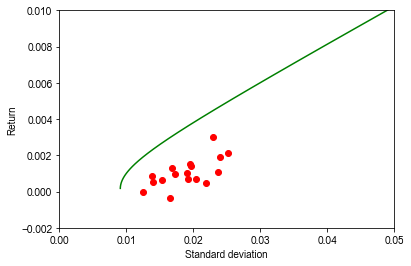

In [41]:
plot_frontier(MV_problem)

#### 禁止做空约束

\begin{align*}
\mathop{maximize} \quad      & \mu^{\prime}w − \gamma w^{\prime} \Sigma w\\
\mathop{subject \, to} \quad & \boldsymbol{1}w=1, w \in \mathcal{W}\\
                             & w >=0
\end{align*}

在下面的实验中我们可以看到，在禁止做空的约束下，意味着同样不能够用多头杠杆，因为我们设定组合是全额投资没有任何净杠杆敞口。所以我们的投资组合可用的资产配置空间也被大大挤压，并且在这样的条件下，组合的最大收益取决于组合中最大收益的股票。

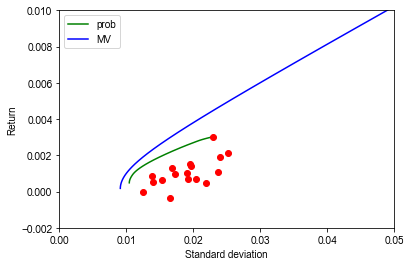

In [42]:
def longonly_problem():
    n = len(meanReturns)
    w = cvx.Variable(n)
    gamma = cvx.Parameter(nonneg=True)
    ret = meanReturns.values.T*w 
    risk = cvx.quad_form(w, covMatrix)
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
                   [cvx.sum(w) == 1,
                    w >= 0])
    return prob,ret,risk,gamma
plot_frontier(longonly_problem,True)

#### 换手率约束

\begin{align*}
\mathop{maximize} \quad      & \mu^{\prime}w − \gamma w^{\prime} \Sigma w\\
\mathop{subject \, to} \quad & \boldsymbol{1}w=1, w \in \mathcal{W}\\
                             & \sum_{i \in \mathcal{I}}\left\lvert w_i \right\lvert <= U
\end{align*}

较高组合换手率意味着较大的交易成本，这会让组合再平衡变得没有效率。所以一个可行的办法是给组合换手率或者单只股票的还手设上限，比如设定每个行业或者板块5%的换手上限。

在下面的实验中我们设定了单只股票10%的换手上限，换手上限这个参数对前沿曲线与马科维茨前沿的离差比较敏感。

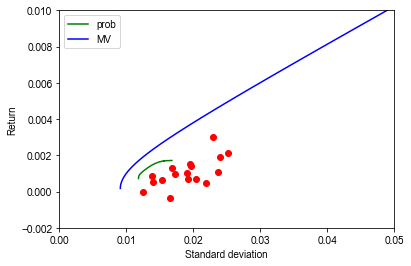

In [43]:
def turnover_problem(U=0.1):
    n = len(meanReturns)
    w = cvx.Variable(n)
    gamma = cvx.Parameter(nonneg=True)
    ret = meanReturns.values.T*w 
    risk = cvx.quad_form(w, covMatrix)
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
                   [cvx.sum(w) == 1,
                    cvx.abs(w) <= U])
    return prob,ret,risk,gamma
plot_frontier(turnover_problem,True)

#### 持有约束

\begin{align*}
\mathop{maximize} \quad      & \mu^{\prime}w − \gamma w^{\prime} \Sigma w\\
\mathop{subject \, to} \quad & \boldsymbol{1}w=1, w \in \mathcal{W}\\
                             & L_i <= w_i <= U_i
\end{align*}

对于一些大型的共同基金，持有一家上市公司的股票，其市值不得超过基金资产净值的10％，有些可能还规定必须持有最低限度某类股票，如蓝筹股。于是，在这些场景中，我们就可以设定持有约束。这个问题也可以对一些投资人偏爱某类股票做建模，对某类股票设定上下限区间。

在我们的实验中，我们对每个股票设定了1%下限和10%的上限，可以看到这样的有效前沿非常”无效“。这样我们就可以理解为什么总体上来说，私募比共同基金更有可能获取更高的收益了。

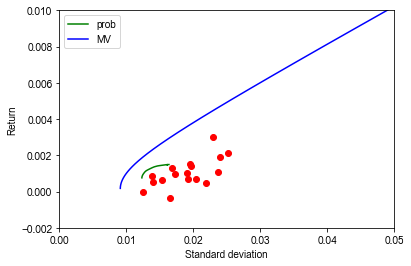

In [44]:
def holding_problem(L=np.ones(len(meanReturns))*0.01,U=np.ones(len(meanReturns))*0.1):
    n = len(meanReturns)
    w = cvx.Variable(n)
    gamma = cvx.Parameter(nonneg=True)
    ret = meanReturns.values.T*w 
    risk = cvx.quad_form(w, covMatrix)
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
                   [cvx.sum(w) == 1,
                    w <= U,
                    w >= L])
    return prob,ret,risk,gamma
plot_frontier(holding_problem,True)

#### 交易成本约束

\begin{align*}
\mathop{maximize} \quad      & \boldsymbol{\mu^{\prime}w} − \gamma \boldsymbol{w^{\prime} \Sigma w} - \lambda \boldsymbol{\theta^{\prime} |w-w_0|}\\
\mathop{subject \, to} \quad & \boldsymbol{1^{\prime} w}=1, \boldsymbol{w} \in \mathcal{W}\\
                             & L_i <= w_i <= U_i
\end{align*}

在实践中，我们一定要考虑到交易成本的因素。交易成本主要分线性成本和非线性成本，线性成本包括手续费、佣金等与交易规模成比例的部分；非线性成本主要是对价格冲击成本的建模。

在我们的这个案例中，暂且只包含线性成本，设定了0.3%的交易佣金，对交易成本的厌恶系数暂且设为0.5。我们可以看到交易成本下的前沿曲线都不是平滑的（我也不知道为啥），并会整体拉低前沿曲线和均值方差前沿的离差，离差与交易成本的厌恶系数比较敏感。

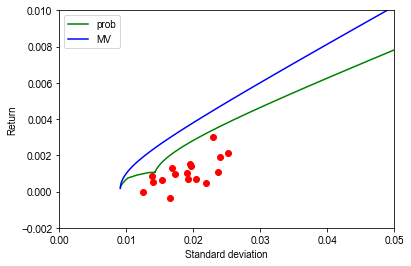

In [45]:
def transaction_problem(w0=np.ones(len(meanReturns))/len(meanReturns),lam=.5,theta=0.003):
    n = len(meanReturns)
    w = cvx.Variable(n)
    gamma = cvx.Parameter(nonneg=True)
    ret = meanReturns.values.T*w 
    risk = cvx.quad_form(w, covMatrix)
    dws = cvx.sum(cvx.abs(w-w0))
    TC = theta*dws
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk - lam*TC), 
                   [cvx.sum(w) == 1])
    return prob,ret,risk,gamma
plot_frontier(transaction_problem,True)

#### 因子模型

\begin{align*}
\mathop{maximize} \quad      & \boldsymbol{\mu^{\prime}w} − \gamma \boldsymbol{w^{\prime} S w}\\
\mathop{subject \, to} \quad & \boldsymbol{1^{\prime} w}=1, \boldsymbol{w} \in \mathcal{W}\\
                             & \boldsymbol{B^{\prime} w = 0}
\end{align*}

在之前的很多篇文章都提高过，对协方差的估计难度是非常大的，用因子模型对协方差建模是业界的一个流行做法。因子组合中可能包含基准（市场因子）因子、规模因子、价值因子、波动率因子、行业因子等，对于风险中性的策略来说，在所有的这些因子暴露都为0，那么整个组合的风险就只有股票自身的特异风险。

一个真正的风险模型在于它对协方差有较高的解释程度，在我们下面的案例中，为简单演示，只考虑了市场因子，会对协方差估计有较大的偏误，不过不影响阐述基本概念。同时，我们的组合还是风险因子中性的，简单说在我们的例子里，模型是市场中性的。

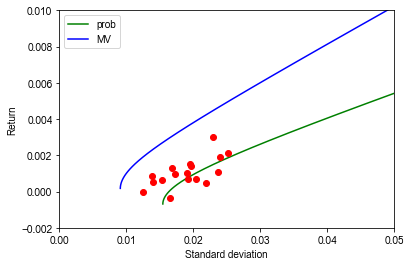

In [46]:
def factor_problem():
    n = len(meanReturns)
    w = cvx.Variable(n)
    gamma = cvx.Parameter(nonneg=True)
    ret = meanReturns.values.T*w 
    f = B.T*w # 因子收益
    D = np.diag(returns.var())
    #Sigma_tilde = np.cov(benchmark_returns.values.T).reshape(m,m) # 系统风险
    risk = cvx.quad_form(w, D)
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk), 
                   [cvx.sum(w) == 1,
                    f == 0])
    return prob,ret,risk,gamma
plot_frontier(factor_problem,True)

#### All in one

在这个实验中，我们把持有约束、交易成本约束以及风险模型综合在一个优化问题中。

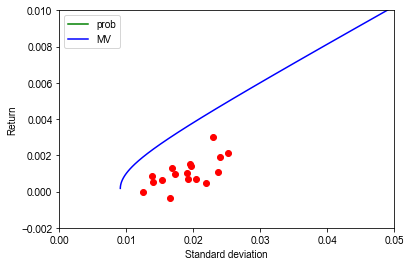

In [47]:
def all_in_one_problem(w0=np.ones(len(meanReturns))/len(meanReturns),lam=.1,theta=0.003,L=-0.1,U=0.1):
    n = len(meanReturns)
    w = cvx.Variable(n)
    gamma = cvx.Parameter(nonneg=True)
    ret = meanReturns.values.T*w 
    f = B.T*w # 因子收益
    D = np.diag(returns.var())
    #risk = cvx.quad_form(w, covMatrix)
    risk = cvx.quad_form(w, D)
    dws = cvx.sum(cvx.abs(w-w0))
    TC = theta*dws
    prob = cvx.Problem(cvx.Maximize(ret - gamma*risk - lam*TC), 
                   [cvx.sum(w) == 1,
                    w >= L,
                    w <= U,
                    f == 0])
    return prob,ret,risk,gamma
plot_frontier(all_in_one_problem,True)

#### 主动投资

\begin{align*}
Maximize \qquad & \boldsymbol{w_a^{\prime} \alpha} - \lambda \boldsymbol{w_a^{\prime} (\Sigma - \beta \beta^{\prime} \sigma_b^2) w_a}
                        = \alpha_p - \lambda \omega_p^2\\
s.t \qquad      & \boldsymbol{w_a^{\prime}} \boldsymbol{1} = 0\\
    \qquad      & \boldsymbol{\beta^{\prime} w_a} = 1
\end{align*}

上面的定义在我们之前的主动投资——信息率的教程里出现过。这里就留给读者自己动手实验一下。

## 总结

我们这里展现了一些最常见的组合优化场景，当然我们还有很多的现实场景没有包含在这篇教程内，其中包括交易整数手约束、股票数量约束、非线性交易成本约束、多账户约束等。另外，我们也没有对其他不同的目标函数做实验，不过基本原理都是相同的。当然不是所有的优化问题都是凸优化问题，但在实践中我们尽可能地将问题表述为优化问题，有几方面原因，其一是实现相对简单，其二是在实际中可行。更一般的问题是MIPS混合整型规划，这个问题在最一般的情景下是NP完全问题，问题的复杂性呈指数级别上升。还有一点需要提醒读者的是，在我们的实验中得到的前沿曲线都是后验曲线，还有一种类型是先验曲线，只需要把$\boldsymbol{\mu}$换成alpha预测向量就ok了。

在这里我们主要想阐述的是量化股票投资组合的pipeline，也就是从alpha生成->组合构建的整条工作流。组合构建或者组合优化是把信息、风险、约束以及偏好系统性地结合在一起。在我个人看来，组合优化与alpha预测都同等重要。

## Alpha系列回顾

- [Alpha系列——股票主动投资组合管理思想和框架](https://community.bigquant.com/t/Alpha%E7%B3%BB%E5%88%97%E2%80%94%E2%80%94%E8%82%A1%E7%A5%A8%E4%B8%BB%E5%8A%A8%E6%8A%95%E8%B5%84%E7%BB%84%E5%90%88%E7%AE%A1%E7%90%86%E6%80%9D%E6%83%B3%E5%92%8C%E6%A1%86%E6%9E%B6/9263/4)
- [Alpha系列——从均值方差到有效前沿](https://community.bigquant.com/t/Alpha%E7%B3%BB%E5%88%97%EF%BC%88%E4%B8%80%EF%BC%89%E2%80%94%E2%80%94%E4%BB%8E%E5%9D%87%E5%80%BC%E6%96%B9%E5%B7%AE%E5%88%B0%E6%9C%89%E6%95%88%E5%89%8D%E6%B2%BF%E3%80%90%E4%BB%A3%E7%A0%81%E5%AE%8C%E6%95%B4%E7%89%88%E3%80%91/9403/1)
- [Alpha系列——从MPT到APT](https://community.bigquant.com/t/Alpha%E7%B3%BB%E5%88%97%EF%BC%88%E4%BA%8C%EF%BC%89%E2%80%94%E2%80%94%E4%BB%8EMPT%E5%88%B0APT/9882)
- [Alpha系列——主动投资管理之信息率](https://community.bigquant.com/t/Alpha%E7%B3%BB%E5%88%97%E4%B8%89%E2%80%94%E2%80%94%E4%B8%BB%E5%8A%A8%E6%8A%95%E8%B5%84%E7%AE%A1%E7%90%86%E4%B9%8B%E4%BF%A1%E6%81%AF%E7%8E%87/10073)
- [Alpha系列——主动管理基本定律（初级篇）](https://community.bigquant.com/t/Alpha%E7%B3%BB%E5%88%97%E2%80%94%E2%80%94%E4%B8%BB%E5%8A%A8%E6%8A%95%E8%B5%84%E7%AE%A1%E7%90%86%E5%AE%9A%E5%BE%8B%EF%BC%88%E5%9F%BA%E6%9C%AC%E7%AF%87%EF%BC%89/10314)
- [Alpha系列——因子模型](https://community.bigquant.com/t/Alpha%E7%B3%BB%E5%88%97%E2%80%94%E2%80%94%E5%9B%A0%E5%AD%90%E6%A8%A1%E5%9E%8B/110235/2)

## 参考文献

1. 《[CVXPY文档](http://www.cvxpy.org/index.html)》
2. 《[A professional quant equity workflow](https://blog.quantopian.com/a-professional-quant-equity-workflow)》
3. 《Quantitative Equity Portfolio Management》
4. 《Optimization and Management》
5. 《主动投资组合管理》
